In [1]:
import duckdb
import boto3

# Credentils and Connection Info
access_key = "minioadmin"
secret_key = "minio123"
endpoint = "localhost:9301"  # MinIO endpoint
region = "eu-west-1"

def duck_s3_connection():
    # Create DuckDB connection to s3 (here local minio)
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs")
    conn.execute("LOAD httpfs")
    conn.execute(f"SET s3_region='{region}'")
    conn.execute("SET s3_url_style='path'")
    conn.execute("SET s3_use_ssl=false")
    conn.execute(f"SET s3_endpoint='{endpoint}'")
    conn.execute(f"SET s3_access_key_id='{access_key}'")
    conn.execute(f"SET s3_secret_access_key='{secret_key}'")
    
    return conn

def list_bucket_objects(bucket_name):
    # Initialize Boto3 S3 client
    session = boto3.Session(
        aws_access_key_id=access_key,
        aws_secret_access_key=secret_key,
    )
    s3 = session.client('s3', endpoint_url = "http://" + endpoint, region_name = region)

    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket = bucket_name)

    obj_keys = []

    for page in pages:
        for obj in page['Contents']:
            key = obj['Key']
            obj_keys.append(key)
            #print(key)
    
    i = len(obj_keys) // 2
    print(f"index: {i}")
    obj_key = obj_keys[i]

    return obj_key

    # List objects within the specified bucket
    #response = s3.list_objects_v2(Bucket=bucket_name)

    # Print the names of all objects
    #if 'Contents' in response:
        #for obj in response['Contents']:
            #print(obj['Key'])
    #else:
        #print("No objects found in the bucket.")


In [2]:
import duckdb

bucket_name = 'enox'
live_prefix = 'live/smartMeter-incoming'

object_name = list_bucket_objects(bucket_name)
print(f"chosen object_name: {object_name}")
split = object_name.split('/')
month = (split[3].split('='))[1]
day = (split[4].split('='))[1]
print(f"day: {day}, month: {month}")


def parquet_info(): 
    try:
        conn = duck_s3_connection()
        print(f"Describe parquet file: { conn.sql(f"""DESCRIBE SELECT *
                       FROM read_parquet('s3://{bucket_name}/{object_name}', hive_partitioning = true) 
                    ;""")}")
        parquet_metadata = conn.sql(f"""SELECT * FROM parquet_metadata('s3://{bucket_name}/{object_name}') 
                    ;""").fetchall()
        print(f"Parquet MetaData: {parquet_metadata}")

        parquet_schema = conn.sql(f"""SELECT * FROM parquet_schema('s3://{bucket_name}/{object_name}') 
                    ;""").fetchall()
        print(f"Parquet Schema: {parquet_schema}")
        #result = conn.fetchall()
        #display(result)
    finally:
        conn.close()


parquet_info()


index: 41
chosen object_name: live/smartMeter-incoming/year=2024/month=09/day=07/smartMeter-incoming+0+0000010000.snappy.parquet
day: 07, month: 09
Describe parquet file: ┌─────────────┬────────────────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │                          column_type                           │  null   │   key   │ default │  extra  │
│   varchar   │                            varchar                             │ varchar │ varchar │ varchar │ varchar │
├─────────────┼────────────────────────────────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ owner       │ STRUCT(id VARCHAR)                                             │ YES     │ NULL    │ NULL    │ NULL    │
│ current     │ STRUCT(L1 STRUCT(centiAmpere BIGINT), L2 STRUCT(centiAmpere …  │ YES     │ NULL    │ NULL    │ NULL    │
│ readingFrom │ VARCHAR                                                        │ YES     │ NULL    │ NU

In [15]:
import pandas as pd
import duckdb

year = 2024
owner_id = ''

def query_parquet():
    try:
        # Connect to DuckDB and load Parquet file
        conn = duck_s3_connection()
        
        df = conn.execute(f"SELECT * FROM read_parquet('s3://{bucket_name}/{object_name}', filename = true, hive_partitioning = true) LIMIT 5").df()
        display(df)
        owner_ids = duckdb.sql("Select owner.id FROM df").fetchall()
        middle = len(owner_ids) // 2
        owner_id = owner_ids[middle][0] #'61c3d063-d6d2'
        print(f"owner_id: {owner_id}")
        conn.execute(f"""SELECT owner, device, energy, readingFrom
                       FROM read_parquet('s3://{bucket_name}/{live_prefix}/**/*.parquet', filename = true) 
                       WHERE year = {year}
                       AND month = {month} 
                       AND day = {day}
                       AND owner.id = '{owner_id}'
                       ORDER BY readingFrom ASC;""")
        print(conn.fetchone()[0])
        result = conn.fetchall()
        print(f"nr of results: {len(result)}")
        display(result)
        df_result = conn.execute(f"""SELECT owner.id as owner_id, 
                                device.deviceId.value as device_id, 
                                SUM(((energy).consumption)."wattHours") as consumption_wh
                       FROM read_parquet('s3://{bucket_name}/{live_prefix}/**/*.parquet', hive_partitioning = true) 
                       WHERE year = {year} 
                       AND month = {month} 
                       GROUP BY device_id, owner_id
                       ORDER BY consumption_wh DESC;""").df()
        display(df_result)
    
    finally:
        # Cleanup
        conn.close()

query_parquet()



,owner,current,readingFrom,meter,id,power,receivedAt,device,energy,voltage,filename,day,month,year
0,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 0}, 'L2': {'centiAmpere...",2024-09-07T15:47:04Z,"{'meterId': {'value': 'Z4-9017385v'}, 'systemT...",{'id': 'i0-5889801S'},"{'feed': {'watt': 49}, 'draw': {'watt': 16}}",2024-09-07T15:47:08Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 9931}, 'feedIn':...","{'L1': {'deciVolt': 9680}, 'L2': {'deciVolt': ...",s3://enox/live/smartMeter-incoming/year=2024/m...,07,09,2024
1,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 8}, 'L2': {'centiAmpere...",2024-09-07T15:47:49Z,"{'meterId': {'value': 'y8-4236715S'}, 'systemT...",{'id': 'V0-6646547c'},"{'feed': {'watt': 39}, 'draw': {'watt': 15}}",2024-09-07T15:47:54Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 3497}, 'feedIn':...","{'L1': {'deciVolt': 9076}, 'L2': {'deciVolt': ...",s3://enox/live/smartMeter-incoming/year=2024/m...,07,09,2024
2,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 1}, 'L2': {'centiAmpere...",2024-09-07T15:48:39Z,"{'meterId': {'value': 't1-6933246h'}, 'systemT...",{'id': 'b9-1152229d'},"{'feed': {'watt': 17}, 'draw': {'watt': 5}}",2024-09-07T15:48:43Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 8240}, 'feedIn':...","{'L1': {'deciVolt': 4643}, 'L2': {'deciVolt': ...",s3://enox/live/smartMeter-incoming/year=2024/m...,07,09,2024
3,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 3}, 'L2': {'centiAmpere...",2024-09-07T15:49:54Z,"{'meterId': {'value': 'J0-1552174x'}, 'systemT...",{'id': 'g5-9003052K'},"{'feed': {'watt': 26}, 'draw': {'watt': 38}}",2024-09-07T15:49:59Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 4447}, 'feedIn':...","{'L1': {'deciVolt': 7458}, 'L2': {'deciVolt': ...",s3://enox/live/smartMeter-incoming/year=2024/m...,07,09,2024
4,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 4}, 'L2': {'centiAmpere...",2024-09-07T15:50:39Z,"{'meterId': {'value': 'C5-2524641v'}, 'systemT...",{'id': 'd1-122711E'},"{'feed': {'watt': 11}, 'draw': {'watt': 35}}",2024-09-07T15:50:42Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 3388}, 'feedIn':...","{'L1': {'deciVolt': 2068}, 'L2': {'deciVolt': ...",s3://enox/live/smartMeter-incoming/year=2024/m...,07,09,2024


owner_id: 64c3d063-d6d5
{'id': '64c3d063-d6d5'}
nr of results: 1626


[({'id': '64c3d063-d6d5'},
  {'deviceId': {'value': 'ECUC012A3101J5.cuculus.net'}},
  {'consumption': {'wattHours': 4552}, 'feedIn': {'wattHours': 2697}},
  '2024-09-07T00:04:09Z'),
 ({'id': '64c3d063-d6d5'},
  {'deviceId': {'value': 'ECUC012A3101J5.cuculus.net'}},
  {'consumption': {'wattHours': 718}, 'feedIn': {'wattHours': 1893}},
  '2024-09-07T00:04:24Z'),
 ({'id': '64c3d063-d6d5'},
  {'deviceId': {'value': 'ECUC012A3101J5.cuculus.net'}},
  {'consumption': {'wattHours': 7079}, 'feedIn': {'wattHours': 2941}},
  '2024-09-07T00:04:29Z'),
 ({'id': '64c3d063-d6d5'},
  {'deviceId': {'value': 'ECUC012A3101J5.cuculus.net'}},
  {'consumption': {'wattHours': 6657}, 'feedIn': {'wattHours': 1406}},
  '2024-09-07T00:05:24Z'),
 ({'id': '64c3d063-d6d5'},
  {'deviceId': {'value': 'ECUC012A3101J5.cuculus.net'}},
  {'consumption': {'wattHours': 9077}, 'feedIn': {'wattHours': 3152}},
  '2024-09-07T00:06:19Z'),
 ({'id': '64c3d063-d6d5'},
  {'deviceId': {'value': 'ECUC012A3101J5.cuculus.net'}},
  {'con

,owner_id,device_id,consumption_wh
0,68c3d063-d6d0,ECUC012A3101N9.cuculus.net,101209173.0
1,67c3d063-d6d9,ECUC012A3101M8.cuculus.net,100418640.0
2,66c3d063-d6d7,ECUC012A3101L7.cuculus.net,100041047.0
3,61c3d063-d6d2,ECUC012A3101G2.cuculus.net,99743748.0
4,60c3d063-d6d1,ECUC012A3101F1.cuculus.net,98632402.0
5,63c3d063-d6d4,ECUC012A3101I4.cuculus.net,94452989.0
6,62c3d063-d6d3,ECUC012A3101H3.cuculus.net,94184893.0
7,59c3d063-d6d8,ECUC012A3101E0.cuculus.net,93725295.0
8,65c3d063-d6d6,ECUC012A3101K6.cuculus.net,93437974.0
9,64c3d063-d6d5,ECUC012A3101J5.cuculus.net,75194639.0


In [17]:
import pandas as pd
import duckdb

table_name = 'parquet_data'
timestamp_column = 'readingFrom'
s3_path = 'copy/results'

def parquet_to_table():
    
    try:
        conn = duck_s3_connection()
        conn.execute(f"CREATE TABLE {table_name} AS SELECT * FROM read_parquet('s3://{bucket_name}/{object_name}')")
        print("loaded parquet to table...")

        # Query data
        result = conn.sql(f"SELECT COUNT(*) FROM {table_name}")
        print(f"describe: {conn.sql(f"SHOW {table_name}")}")
        print(f"Number of rows in table: {result.fetchone()[0]}")
        df = conn.execute(f"SELECT * FROM {table_name}").df()
        display(df)   

        conn.execute(f"""COPY {table_name}
                         TO 's3://{bucket_name}/{s3_path}/{table_name}' (FORMAT PARQUET, PARTITION_BY (year, month));""")
        print("loaded parquet to parquet...")

        df = conn.execute(f"SELECT * FROM read_parquet('s3://{bucket_name}/{s3_path}/**/*.parquet')").df()
        display(df)
    
    finally:
        # Cleanup
        conn.close()

parquet_to_table()



loaded parquet to table...
describe: ┌─────────────┬────────────────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │                          column_type                           │  null   │   key   │ default │  extra  │
│   varchar   │                            varchar                             │ varchar │ varchar │ varchar │ varchar │
├─────────────┼────────────────────────────────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ owner       │ STRUCT(id VARCHAR)                                             │ YES     │ NULL    │ NULL    │ NULL    │
│ current     │ STRUCT(L1 STRUCT(centiAmpere BIGINT), L2 STRUCT(centiAmpere …  │ YES     │ NULL    │ NULL    │ NULL    │
│ readingFrom │ VARCHAR                                                        │ YES     │ NULL    │ NULL    │ NULL    │
│ meter       │ STRUCT(meterId STRUCT("value" VARCHAR), systemTitle STRUCT("…  │ YES     │ NULL    │ NULL    │ NULL 

,owner,current,readingFrom,meter,id,power,receivedAt,device,energy,voltage,day,month,year
0,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 0}, 'L2': {'centiAmpere...",2024-09-07T15:47:04Z,"{'meterId': {'value': 'Z4-9017385v'}, 'systemT...",{'id': 'i0-5889801S'},"{'feed': {'watt': 49}, 'draw': {'watt': 16}}",2024-09-07T15:47:08Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 9931}, 'feedIn':...","{'L1': {'deciVolt': 9680}, 'L2': {'deciVolt': ...",07,09,2024
1,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 8}, 'L2': {'centiAmpere...",2024-09-07T15:47:49Z,"{'meterId': {'value': 'y8-4236715S'}, 'systemT...",{'id': 'V0-6646547c'},"{'feed': {'watt': 39}, 'draw': {'watt': 15}}",2024-09-07T15:47:54Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 3497}, 'feedIn':...","{'L1': {'deciVolt': 9076}, 'L2': {'deciVolt': ...",07,09,2024
2,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 1}, 'L2': {'centiAmpere...",2024-09-07T15:48:39Z,"{'meterId': {'value': 't1-6933246h'}, 'systemT...",{'id': 'b9-1152229d'},"{'feed': {'watt': 17}, 'draw': {'watt': 5}}",2024-09-07T15:48:43Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 8240}, 'feedIn':...","{'L1': {'deciVolt': 4643}, 'L2': {'deciVolt': ...",07,09,2024
3,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 3}, 'L2': {'centiAmpere...",2024-09-07T15:49:54Z,"{'meterId': {'value': 'J0-1552174x'}, 'systemT...",{'id': 'g5-9003052K'},"{'feed': {'watt': 26}, 'draw': {'watt': 38}}",2024-09-07T15:49:59Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 4447}, 'feedIn':...","{'L1': {'deciVolt': 7458}, 'L2': {'deciVolt': ...",07,09,2024
4,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 4}, 'L2': {'centiAmpere...",2024-09-07T15:50:39Z,"{'meterId': {'value': 'C5-2524641v'}, 'systemT...",{'id': 'd1-122711E'},"{'feed': {'watt': 11}, 'draw': {'watt': 35}}",2024-09-07T15:50:42Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 3388}, 'feedIn':...","{'L1': {'deciVolt': 2068}, 'L2': {'deciVolt': ...",07,09,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 0}, 'L2': {'centiAmpere...",2024-09-07T23:55:59Z,"{'meterId': {'value': 'w3-4075249D'}, 'systemT...",{'id': 'm9-1037854M'},"{'feed': {'watt': 29}, 'draw': {'watt': 21}}",2024-09-07T23:56:03Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 4215}, 'feedIn':...","{'L1': {'deciVolt': 1755}, 'L2': {'deciVolt': ...",07,09,2024
549,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 1}, 'L2': {'centiAmpere...",2024-09-07T23:58:09Z,"{'meterId': {'value': 'N3-3979193n'}, 'systemT...",{'id': 'd8-8651108I'},"{'feed': {'watt': 51}, 'draw': {'watt': 23}}",2024-09-07T23:58:11Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 1664}, 'feedIn':...","{'L1': {'deciVolt': 9542}, 'L2': {'deciVolt': ...",07,09,2024
550,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 6}, 'L2': {'centiAmpere...",2024-09-07T23:58:24Z,"{'meterId': {'value': 'M7-9663389a'}, 'systemT...",{'id': 'O3-7517504N'},"{'feed': {'watt': 51}, 'draw': {'watt': 34}}",2024-09-07T23:58:27Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 4512}, 'feedIn':...","{'L1': {'deciVolt': 244}, 'L2': {'deciVolt': 3...",07,09,2024
551,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 9}, 'L2': {'centiAmpere...",2024-09-07T23:59:19Z,"{'meterId': {'value': 'p2-7652654x'}, 'systemT...",{'id': 'j6-6573620l'},"{'feed': {'watt': 39}, 'draw': {'watt': 35}}",2024-09-07T23:59:20Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 8734}, 'feedIn':...","{'L1': {'deciVolt': 7590}, 'L2': {'deciVolt': ...",07,09,2024


loaded parquet to parquet...


,owner,current,readingFrom,meter,id,power,receivedAt,device,energy,voltage,day,month,year
0,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 0}, 'L2': {'centiAmpere...",2024-09-07T15:47:04Z,"{'meterId': {'value': 'Z4-9017385v'}, 'systemT...",{'id': 'i0-5889801S'},"{'feed': {'watt': 49}, 'draw': {'watt': 16}}",2024-09-07T15:47:08Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 9931}, 'feedIn':...","{'L1': {'deciVolt': 9680}, 'L2': {'deciVolt': ...",07,09,2024
1,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 8}, 'L2': {'centiAmpere...",2024-09-07T15:47:49Z,"{'meterId': {'value': 'y8-4236715S'}, 'systemT...",{'id': 'V0-6646547c'},"{'feed': {'watt': 39}, 'draw': {'watt': 15}}",2024-09-07T15:47:54Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 3497}, 'feedIn':...","{'L1': {'deciVolt': 9076}, 'L2': {'deciVolt': ...",07,09,2024
2,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 1}, 'L2': {'centiAmpere...",2024-09-07T15:48:39Z,"{'meterId': {'value': 't1-6933246h'}, 'systemT...",{'id': 'b9-1152229d'},"{'feed': {'watt': 17}, 'draw': {'watt': 5}}",2024-09-07T15:48:43Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 8240}, 'feedIn':...","{'L1': {'deciVolt': 4643}, 'L2': {'deciVolt': ...",07,09,2024
3,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 3}, 'L2': {'centiAmpere...",2024-09-07T15:49:54Z,"{'meterId': {'value': 'J0-1552174x'}, 'systemT...",{'id': 'g5-9003052K'},"{'feed': {'watt': 26}, 'draw': {'watt': 38}}",2024-09-07T15:49:59Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 4447}, 'feedIn':...","{'L1': {'deciVolt': 7458}, 'L2': {'deciVolt': ...",07,09,2024
4,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 4}, 'L2': {'centiAmpere...",2024-09-07T15:50:39Z,"{'meterId': {'value': 'C5-2524641v'}, 'systemT...",{'id': 'd1-122711E'},"{'feed': {'watt': 11}, 'draw': {'watt': 35}}",2024-09-07T15:50:42Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 3388}, 'feedIn':...","{'L1': {'deciVolt': 2068}, 'L2': {'deciVolt': ...",07,09,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 0}, 'L2': {'centiAmpere...",2024-09-07T23:55:59Z,"{'meterId': {'value': 'w3-4075249D'}, 'systemT...",{'id': 'm9-1037854M'},"{'feed': {'watt': 29}, 'draw': {'watt': 21}}",2024-09-07T23:56:03Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 4215}, 'feedIn':...","{'L1': {'deciVolt': 1755}, 'L2': {'deciVolt': ...",07,09,2024
549,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 1}, 'L2': {'centiAmpere...",2024-09-07T23:58:09Z,"{'meterId': {'value': 'N3-3979193n'}, 'systemT...",{'id': 'd8-8651108I'},"{'feed': {'watt': 51}, 'draw': {'watt': 23}}",2024-09-07T23:58:11Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 1664}, 'feedIn':...","{'L1': {'deciVolt': 9542}, 'L2': {'deciVolt': ...",07,09,2024
550,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 6}, 'L2': {'centiAmpere...",2024-09-07T23:58:24Z,"{'meterId': {'value': 'M7-9663389a'}, 'systemT...",{'id': 'O3-7517504N'},"{'feed': {'watt': 51}, 'draw': {'watt': 34}}",2024-09-07T23:58:27Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 4512}, 'feedIn':...","{'L1': {'deciVolt': 244}, 'L2': {'deciVolt': 3...",07,09,2024
551,{'id': '64c3d063-d6d5'},"{'L1': {'centiAmpere': 9}, 'L2': {'centiAmpere...",2024-09-07T23:59:19Z,"{'meterId': {'value': 'p2-7652654x'}, 'systemT...",{'id': 'j6-6573620l'},"{'feed': {'watt': 39}, 'draw': {'watt': 35}}",2024-09-07T23:59:20Z,{'deviceId': {'value': 'ECUC012A3101J5.cuculus...,"{'consumption': {'wattHours': 8734}, 'feedIn':...","{'L1': {'deciVolt': 7590}, 'L2': {'deciVolt': ...",07,09,2024


In [ ]:
import pandas as pd
import duckdb

def parquet_to_parquet():
    #table_name = 'cache'
    timestamp_column = 'readingFrom'
    s3_path = 'copy/results'
    try:
        conn = duck_s3_connection()
        result = conn.sql(f"SELECT COUNT(*) FROM {table_name}")
        print(f"Number of rows in table: {result.fetchone()[0]}")
        
        conn.execute(f"""COPY ( 
                            SELECT *
                            FROM {table_name}
                    ) TO 's3://{bucket_name}/{s3_path}/{table_name}/results-snappy.parquet' (FORMAT PARQUET, COMPRESSION 'snappy');""")
        print("loaded parquet to parquet...")

        df = conn.execute(f"SELECT * FROM read_parquet('s3://{bucket_name}/{s3_path}/**/*.parquet')").df()
        display(df)
    
    finally:
        # Cleanup
        conn.close()

parquet_to_parquet()

In [18]:
import numpy as np
import ruptures as rpt
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
def calculate_scp_stats(vals):
    #sort values
    vals.sort()
    signal = np.array(vals)
    width = int(0.1 * len(signal))

    # Change point detection
    model = "l2"
    algo = rpt.Window(width=width, model=model).fit(signal)
    
    #this calculates the index, not the value
    my_bkps_idx = algo.predict(n_bkps=2)

    try:
        my_bkps = [signal[my_bkps_idx[0]], signal[my_bkps_idx[1]]]
    except IndexError:
        my_bkps = [signal[my_bkps_idx[0]], signal[-1]]

    return my_bkps

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/var/folders/4j/plgykz0x47162rmjs3fq72340000gn/T/ipykernel_88355/376172831.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.week = df.index.isocalendar().week


<IntegerArray>
[35, 36, 37]
Length: 3, dtype: UInt32

len of myvalues: 2840
len of myvalues: 120960
len of myvalues: 66200


<Axes: title={'center': 'Rolling values (4 weeks)'}>

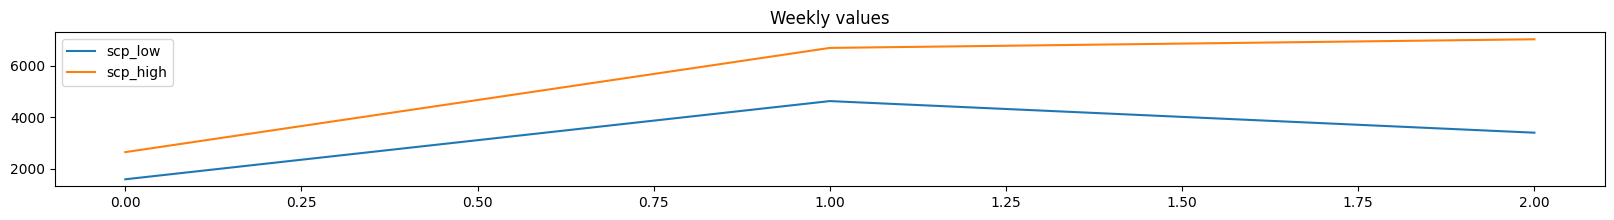

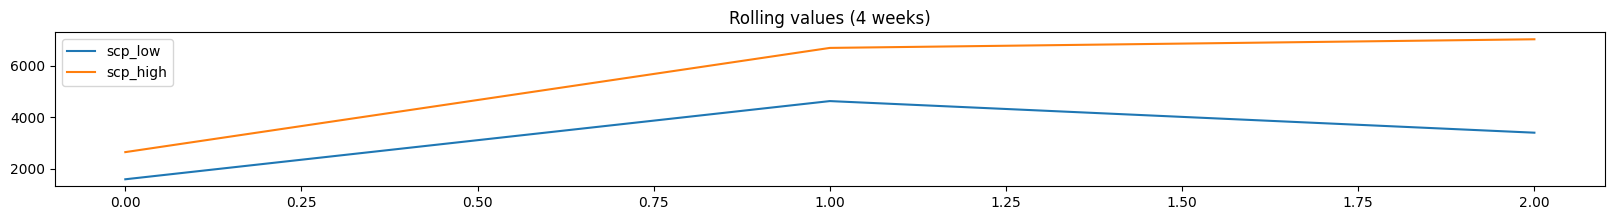

In [20]:
conn = duck_s3_connection()
        
df = conn.execute(f"SELECT * FROM read_parquet('s3://{bucket_name}/{live_prefix}/**/*.parquet', hive_partitioning = true)").df()

#display(df)
#display(df.readingFrom)
#display(df.energy.apply(lambda x: x.get('consumption').get('wattHours')))


df.readingFrom = pd.to_datetime(df.readingFrom, dayfirst=False)
df.set_index("readingFrom",inplace=True)

# add calendar week
df.week = df.index.isocalendar().week
weeklist = df.week.unique()
display(weeklist)

# calculate the breakpoints
weeklybreakpoints = []
for week in weeklist:
    myvalues = df[df.week == week].energy.apply(lambda x: float(x.get('consumption').get('wattHours'))).values
    print(f"len of myvalues: {len(myvalues)}")
    if len(myvalues) > 400:
        breakpoints = calculate_scp_stats(myvalues)
        weeklybreakpoints.append([week]+breakpoints)

# calculate the rolling values (12 weeks)
df_bp = pd.DataFrame(weeklybreakpoints,columns=["week","scp_low","scp_high"])
#df_bp_rolling_12 = df_bp[["scp_low","scp_high"]].rolling(12,min_periods=1).mean()
#df_bp_rolling_8 = df_bp[["scp_low","scp_high"]].rolling(8,min_periods=1).mean()
#df_bp_rolling_6 = df_bp[["scp_low","scp_high"]].rolling(6,min_periods=1).mean()
df_bp_rolling_4 = df_bp[["scp_low","scp_high"]].rolling(1,min_periods=1).mean()
ax = df_bp[["scp_low","scp_high"]].plot(figsize=(20,2),title="Weekly values")
#df_bp_rolling_12.plot(figsize=(20,2),title="Rolling values (12 weeks)");
#df_bp_rolling_8.plot(figsize=(20,2),title="Rolling values (8 weeks)");
#df_bp_rolling_6.plot(figsize=(20,2),title="Rolling values (6 weeks)");
df_bp_rolling_4.plot(figsize=(20,2),title="Rolling values (4 weeks)")
